In [1]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


In [2]:
restaurant_frequency = defaultdict(int)

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        categories = json_line.get('categories')
        if categories and 'Chinese' in categories and 'Restaurants' in categories:
            city = json_line.get('city', 'Unknown')
            restaurant_frequency[city] += 1

            
sorted_restaurant_frequency = sorted(restaurant_frequency.items(), key=lambda item: item[1], reverse=True)
# sorted_restaurant_frequency

In [3]:
restaurants_data = []

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if 'categories' in json_line and 'state' in json_line:
            state = json_line['state']
            city = json_line['city']
            categories = json_line['categories']
            if categories and 'Chinese' in categories and 'Restaurants' in categories and state == 'PA' and city == 'Philadelphia':
                restaurants_data.append(json_line)

all_keys = set()
for restaurant in restaurants_data:
    if 'attributes' in restaurant and restaurant['attributes']:
        all_keys.update(restaurant['attributes'].keys())

split_attributes_list = []
for restaurant in restaurants_data:
    new_restaurant_data = {k: v for k, v in restaurant.items() if k != 'attributes'}
    attributes_data = {}
    if 'attributes' in restaurant and restaurant['attributes']:
        for key in all_keys:
            if key in restaurant['attributes']:
                try:
                    value = restaurant['attributes'][key].replace("'", '"')
                    attributes_data[key] = json.loads(value)
                except json.JSONDecodeError:
                    attributes_data[key] = restaurant['attributes'][key]
            else:
                attributes_data[key] = None
    new_restaurant_data.update(attributes_data)
    split_attributes_list.append(new_restaurant_data)
    
split_business = pd.DataFrame(split_attributes_list)
split_business.rename(columns={'stars': 'avg_star'}, inplace=True)

valid_categories = ['Asian Fusion', 'Dim Sum', 'Seafood', 'Szechuan', 'Noodles', 'Fast Food', 'Hot Pot']

def filter_categories(row):
    categories = row['categories'].split(', ')
    filtered_categories = [category for category in categories if category in valid_categories]
    return ', '.join(filtered_categories) if filtered_categories else 'Other'

split_business['categories'] = split_business.apply(filter_categories, axis=1)
# split_business.info()

In [4]:
columns_to_keep = ['business_id', 'name', 'postal_code', 'avg_star', 'review_count', 'categories',
                   'is_open', 'RestaurantsGoodForGroups', 'OutdoorSeating', 
                   'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsReservations',
                   'RestaurantsDelivery', 'RestaurantsPriceRange2']
business_df = split_business[columns_to_keep]
business_df = business_df.rename(columns={'RestaurantsGoodForGroups': 'GoodForGroups',
                                          'BusinessAcceptsCreditCards': 'AcceptsCreditCards',
                                          'RestaurantsTakeOut': 'TakeOut',
                                          'RestaurantsReservations': 'Reservations',
                                          'RestaurantsDelivery': 'Delivery',
                                          'RestaurantsPriceRange2': 'PriceRange'})
# business_df['postal_code'].value_counts()

In [5]:
columns_of_interest = ['GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards',
                       'TakeOut', 'Reservations', 'Delivery']

for col in columns_of_interest:
    business_df.loc[:, col] = business_df[col].apply(lambda x: True if x == 'True' else False)
    
# business_df['BusinessAcceptsCreditCards'].value_counts()
business_df = business_df[business_df['is_open'] == 1]

def assign_block(postal_code):
    if postal_code in ['19102', '19103', '19106', '19107']:
        return 'Center'
    elif postal_code in ['19104', '19131', '19139', '19143', '19151', '19142']:
        return 'West'
    elif postal_code in ['19112', '19145', '19146', '19147', '19148', '19153']:
        return 'South'
    elif postal_code in ['19111', '19114', '19115', '19116', '19124', '19125', '19134', 
                         '19135', '19136', '19137', '19149', '19152', '19154']:
        return 'East'
    else:
        return 'North'

business_df['block'] = business_df['postal_code'].apply(assign_block)
business_df['star_rank'] = business_df.groupby('block')['avg_star'].rank(ascending=False, method='min').astype(int)
business_df

,business_id,name,postal_code,avg_star,review_count,categories,is_open,GoodForGroups,OutdoorSeating,AcceptsCreditCards,TakeOut,Reservations,Delivery,PriceRange,block,star_rank
0,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,3.0,137,Other,1,True,False,True,True,True,True,1.0,North,48
2,V5KiEoH4E86GA2S3RQkf1g,Spice Grill,19134,3.5,12,Asian Fusion,1,True,False,True,True,False,True,1.0,East,17
3,MMRRS6YhVRx_iN5-JhMRYg,Han Dynasty,19104,4.0,783,Szechuan,1,True,False,True,True,True,True,2.0,West,5
5,n6dw_zxL_4cVO6EP_m0joQ,Dragon House,19107,4.0,5,Other,1,False,False,False,False,False,False,NaN,Center,18
6,Zk_GdMMPgEfKUECCxAxvwQ,Pho Nam Giang,19154,4.5,23,Asian Fusion,1,False,False,True,True,False,True,2.0,East,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,qDEcJ48kXdWxQGZefgG94w,Xun Yu Si Kao,19107,4.0,114,"Seafood, Hot Pot",1,True,False,True,True,True,False,2.0,Center,18
467,hUmHwBQtGg0iH-PZakQJDw,Wm Mulherin's Sons,19122,4.5,610,Szechuan,1,True,True,True,True,True,True,3.0,North,4
468,xwyRa1tu9V3_JGHMiCg8Og,Shi Miao Dao Yunnan Rice Noodle,19107,4.0,56,Noodles,1,False,False,False,True,False,True,2.0,Center,18
469,0cHDa2cXCF4PZzO2krXypg,Bo Sing,19104,4.0,12,Asian Fusion,1,True,False,False,True,False,False,1.0,West,5


In [6]:
business_ids = set(business_df['business_id'])

reviews_data = []
with open('review.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if json_line['business_id'] in business_ids:
            reviews_data.append(json_line)

reviews_df = pd.DataFrame(reviews_data)
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df['date'] = reviews_df['date'].dt.strftime('%Y-%m-%d')
reviews_df = reviews_df.sort_values(by='date')
# reviews_df

In [7]:
total_reviews = reviews_df['business_id'].value_counts()
total_reviews_df = pd.DataFrame({'business_id': total_reviews.index, 'total_reviews': total_reviews.values})
merged = pd.merge(business_df, total_reviews_df, on='business_id', how='left')
merged = merged[['business_id', 'name', 'block', 'postal_code', 'avg_star', 'star_rank', 'total_reviews', 'categories',
                 'GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut',
                 'Reservations', 'Delivery', 'PriceRange']]
reviews = reviews_df[(reviews_df['date'] >= '2019-01-01') & (reviews_df['date'] <= '2021-12-31')]
review_counts = reviews['business_id'].value_counts().reset_index()
review_counts.columns = ['business_id', 'review']
merged = pd.merge(merged, review_counts, on='business_id', how='left')
merged['review'] = merged['review'].fillna(0).astype(int)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   business_id         300 non-null    object 
 1   name                300 non-null    object 
 2   block               300 non-null    object 
 3   postal_code         300 non-null    object 
 4   avg_star            300 non-null    float64
 5   star_rank           300 non-null    int64  
 6   total_reviews       300 non-null    int64  
 7   categories          300 non-null    object 
 8   GoodForGroups       300 non-null    object 
 9   OutdoorSeating      300 non-null    object 
 10  AcceptsCreditCards  300 non-null    object 
 11  TakeOut             300 non-null    object 
 12  Reservations        300 non-null    object 
 13  Delivery            300 non-null    object 
 14  PriceRange          256 non-null    float64
 15  review              300 non-null    int64  
dtypes: float

In [8]:
def replace_with_percentage(df, columns):
    percentage_df = df.groupby('block')[columns].apply(lambda x: x.sum() / len(x) * 100).round().astype(int)
    merged_df = df.drop(columns=columns).merge(percentage_df, left_on='block', right_index=True)
    return merged_df

columns_to_replace = ['GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery']
replaced_df = replace_with_percentage(merged, columns_to_replace)
replaced_df

,business_id,name,block,postal_code,avg_star,star_rank,total_reviews,categories,PriceRange,review,GoodForGroups,OutdoorSeating,AcceptsCreditCards,TakeOut,Reservations,Delivery
0,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,North,19130,3.0,48,147,Other,1.0,38,49,13,58,94,32,65
5,sfbg2kxnvKpmlIuCUas5TA,Lucky Wok Restaurant,North,19120,2.5,62,6,Other,1.0,0,49,13,58,94,32,65
7,teGUSCn6Vlrs07qIgilFHA,Oriental Kitchen,North,19130,2.5,62,8,Other,NaN,8,49,13,58,94,32,65
13,qfFKVxDqFbPtBTlKGQDapQ,Master Wok,North,19122,3.5,26,9,Other,1.0,1,49,13,58,94,32,65
15,R76nXl5oTep-d1ZGPZSimQ,Trio Breakfast & Lunch,North,19144,3.0,48,37,Fast Food,1.0,6,49,13,58,94,32,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,SYt5vLiLkNCkYfN5CCqVFg,Oriental Chinese,South,19148,3.0,29,43,Other,1.0,8,56,8,69,95,38,79
274,1Ggw9DE7s9h4q9sRo-f3oA,Happy Dragon Chinese Restaurant,South,19148,3.5,20,43,Asian Fusion,2.0,11,56,8,69,95,38,79
282,qjIN4UbE96Cq6JKwLIQ9VQ,Saloon Restaurant,South,19147,4.5,3,191,Other,3.0,55,56,8,69,95,38,79
285,jh-Sg2S4wlelkifvhjwSlg,China Garden,South,19145,3.5,20,53,Other,1.0,11,56,8,69,95,38,79


In [9]:
grouped = merged.groupby('block')

percentage = pd.DataFrame(columns=['block', 'element', 'GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery'])

for block, group in grouped:
    counts = group[['GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery']].apply(lambda x: x.value_counts(normalize=True))
    counts = counts.fillna(0)
    counts = (counts * 100).round().astype(int)
    counts['block'] = block
    counts['element'] = ['True', 'False']
    percentage = pd.concat([percentage, counts.reset_index(drop=True)], ignore_index=True)

percentage

,block,element,GoodForGroups,OutdoorSeating,AcceptsCreditCards,TakeOut,Reservations,Delivery
0,Center,True,29,88,30,18,59,32
1,Center,False,71,12,70,82,41,68
2,East,True,47,96,17,0,75,15
3,East,False,53,4,83,100,25,85
4,North,True,51,87,42,6,68,35
5,North,False,49,13,58,94,32,65
6,South,True,44,92,31,5,62,21
7,South,False,56,8,69,95,38,79
8,West,True,39,87,45,5,74,32
9,West,False,61,13,55,95,26,68


In [10]:
df = pd.read_csv('Trips_by_Distance.csv')
pa_trip = df[(df['State Postal Code'] == 'PA') & (df['County Name'] == 'Philadelphia County')].copy()
pa_trip['Date'] = pd.to_datetime(pa_trip['Date']).dt.strftime('%Y-%m-%d')
pa_trip.rename(columns={'Date': 'date'}, inplace=True)
pa_trip = pa_trip.sort_values(by='date')
trip = pd.merge(pa_trip, reviews, on='date', how='inner')
# trip

In [11]:
trip['date'] = pd.to_datetime(trip['date'])

monthly_summary = trip.groupby(trip['date'].dt.to_period('M')).agg(
    Mean_Trips=('Number of Trips', 'mean'),
    Text_Count=('text', 'count')
).reset_index()

monthly_summary.rename(columns={'date': 'Month'}, inplace=True)
monthly_summary['Month'] = monthly_summary['Month'].dt.strftime('%Y-%m')
monthly_summary.head()

,Month,Mean_Trips,Text_Count
0,2019-01,5.039268e+06,545
1,2019-02,5.108103e+06,497
2,2019-03,5.662449e+06,559
3,2019-04,5.852427e+06,507
4,2019-05,5.912995e+06,504


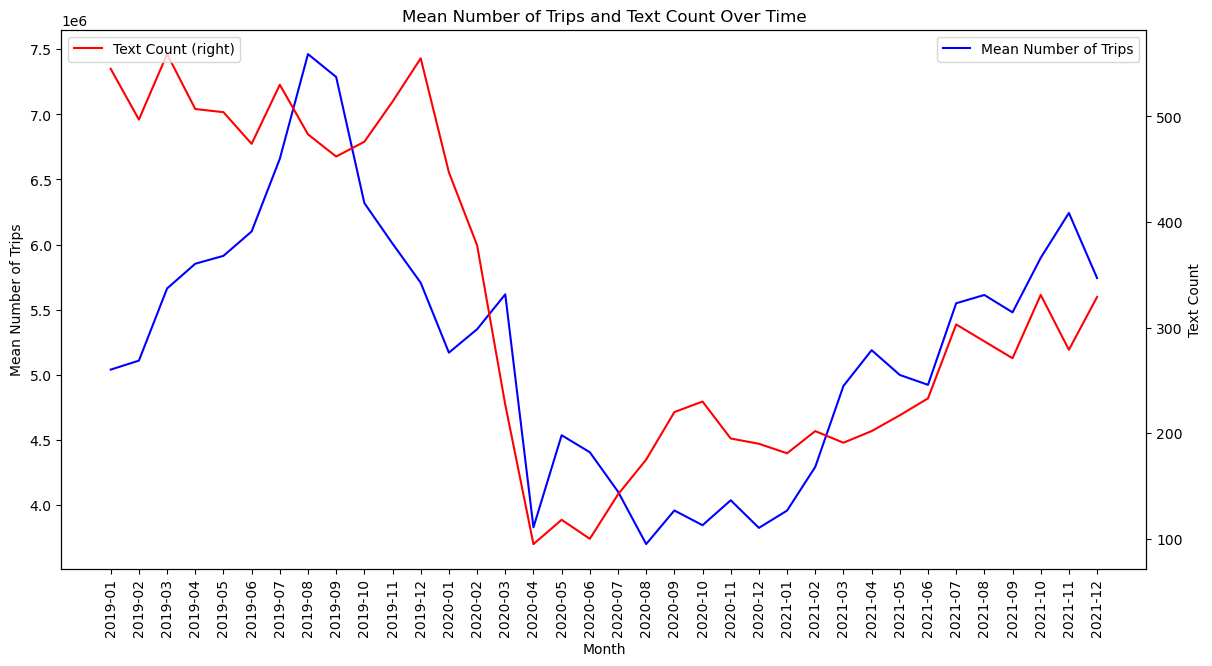

In [50]:
monthly_summary.sort_values('Month', inplace=True)
plt.figure(figsize=(14,7))
ax1 = monthly_summary['Mean_Trips'].plot(color='blue', grid=False, label='Mean Number of Trips')
ax2 = monthly_summary['Text_Count'].plot(color='red', grid=False, secondary_y=True, label='Text Count')
ax1.legend(loc=1)
ax2.legend(loc=2)
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean Number of Trips')
ax2.set_ylabel('Text Count')
ax1.set_xticks(range(len(monthly_summary)))
ax1.set_xticklabels(monthly_summary['Month'], rotation=90)
plt.title('Mean Number of Trips and Text Count Over Time')
plt.show()

In [13]:
business = business_df[business_df['is_open'] == True]
business['postal_code'].value_counts()

postal_code
19107    64
19104    18
19148    18
19147    12
19149    11
19123    10
19124    10
19103    10
19114     8
19130     7
19134     7
19128     7
19115     7
19111     7
19118     6
19121     6
19131     6
19145     5
19143     5
19152     5
19144     5
19120     5
19140     4
19122     4
19106     4
19154     4
19102     4
19135     4
19136     4
19142     4
19150     4
19116     3
19146     3
19151     3
19127     3
19139     2
19119     2
19133     1
19138     1
19132     1
19141     1
19125     1
19153     1
19195     1
19129     1
19137     1
Name: count, dtype: int64

In [14]:
A_1 = merged[['business_id', 'name', 'postal_code', 'block', 'avg_star', 'star_rank', 'total_reviews', 'categories', 'review']]
A_1.loc[:, 'comment_rank'] = A_1.groupby('block')['review'].rank(method='dense', ascending=False).astype(int)
# A_1.to_csv('A_1.csv', index=False)
B_1 = merged[['business_id', 'block', 'GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery', 'PriceRange']]
B_1

/var/folders/fy/rpyls8xn43qfld_523dfst600000gn/T/ipykernel_41467/994540275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_1.loc[:, 'comment_rank'] = A_1.groupby('block')['review'].rank(method='dense', ascending=False).astype(int)


,business_id,block,GoodForGroups,OutdoorSeating,AcceptsCreditCards,TakeOut,Reservations,Delivery,PriceRange
0,3BJxm-HnvzdwD1zjmSbmyQ,North,True,False,True,True,True,True,1.0
1,V5KiEoH4E86GA2S3RQkf1g,East,True,False,True,True,False,True,1.0
2,MMRRS6YhVRx_iN5-JhMRYg,West,True,False,True,True,True,True,2.0
3,n6dw_zxL_4cVO6EP_m0joQ,Center,False,False,False,False,False,False,NaN
4,Zk_GdMMPgEfKUECCxAxvwQ,East,False,False,True,True,False,True,2.0
...,...,...,...,...,...,...,...,...,...
295,qDEcJ48kXdWxQGZefgG94w,Center,True,False,True,True,True,False,2.0
296,hUmHwBQtGg0iH-PZakQJDw,North,True,True,True,True,True,True,3.0
297,xwyRa1tu9V3_JGHMiCg8Og,Center,False,False,False,True,False,True,2.0
298,0cHDa2cXCF4PZzO2krXypg,West,True,False,False,True,False,False,1.0


In [15]:
def T_perc_columns(df):
    df_copy = df.copy()
    for column in ['GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery']:
        percentage = df.groupby('block')[column].apply(lambda x: (x == True).sum() / x.count())
        percentage = (percentage * 100).round(1)
        df_copy.loc[:, f'T_{column}'] = df['block'].map(percentage)
    return df_copy

def F_perc_columns(df):
    df_copy = df.copy()
    for column in ['GoodForGroups', 'OutdoorSeating', 'AcceptsCreditCards', 'TakeOut', 'Reservations', 'Delivery']:
        percentage = df.groupby('block')[column].apply(lambda x: (x == False).sum() / x.count())
        percentage = (percentage * 100).round(1)
        df_copy.loc[:, f'F_{column}'] = df['block'].map(percentage)
    return df_copy

def price_range_perc(df):
    df_copy = df.copy()
    price_ranges = [1.0, 2.0, 3.0, 4.0]
    total_counts = df.groupby('block')['PriceRange'].size()
    nan_percentage = df.groupby('block')['PriceRange'].apply(lambda x: x.isna().sum()) / total_counts
    nan_percentage = (nan_percentage * 100).round(1)
    df_copy['PriceRange_NaN'] = df['block'].map(nan_percentage)
    for value in price_ranges:
        percentage = df.groupby('block')['PriceRange'].apply(lambda x: (x == value).sum()) / total_counts
        percentage = (percentage * 100).round(1)
        df_copy[f'PriceRange_{value}'] = df['block'].map(percentage)
    return df_copy

B_1 = T_perc_columns(B_1)
B_1 = F_perc_columns(B_1)
B_1 = price_range_perc(B_1)
B_1

,business_id,block,GoodForGroups,OutdoorSeating,AcceptsCreditCards,TakeOut,Reservations,Delivery,PriceRange,T_GoodForGroups,...,F_OutdoorSeating,F_AcceptsCreditCards,F_TakeOut,F_Reservations,F_Delivery,PriceRange_NaN,PriceRange_1.0,PriceRange_2.0,PriceRange_3.0,PriceRange_4.0
0,3BJxm-HnvzdwD1zjmSbmyQ,North,True,False,True,True,True,True,1.0,49.3,...,87.0,42.0,5.8,68.1,34.8,18.8,44.9,33.3,1.4,1.4
1,V5KiEoH4E86GA2S3RQkf1g,East,True,False,True,True,False,True,1.0,52.8,...,95.8,16.7,0.0,75.0,15.3,11.1,43.1,44.4,0.0,1.4
2,MMRRS6YhVRx_iN5-JhMRYg,West,True,False,True,True,True,True,2.0,60.5,...,86.8,44.7,5.3,73.7,31.6,13.2,57.9,28.9,0.0,0.0
3,n6dw_zxL_4cVO6EP_m0joQ,Center,False,False,False,False,False,False,NaN,70.7,...,87.8,30.5,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0
4,Zk_GdMMPgEfKUECCxAxvwQ,East,False,False,True,True,False,True,2.0,52.8,...,95.8,16.7,0.0,75.0,15.3,11.1,43.1,44.4,0.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,qDEcJ48kXdWxQGZefgG94w,Center,True,False,True,True,True,False,2.0,70.7,...,87.8,30.5,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0
296,hUmHwBQtGg0iH-PZakQJDw,North,True,True,True,True,True,True,3.0,49.3,...,87.0,42.0,5.8,68.1,34.8,18.8,44.9,33.3,1.4,1.4
297,xwyRa1tu9V3_JGHMiCg8Og,Center,False,False,False,True,False,True,2.0,70.7,...,87.8,30.5,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0
298,0cHDa2cXCF4PZzO2krXypg,West,True,False,False,True,False,False,1.0,60.5,...,86.8,44.7,5.3,73.7,31.6,13.2,57.9,28.9,0.0,0.0


In [16]:
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews['month'] = reviews['date'].dt.to_period('M')
mean_star_by_month = reviews.groupby(['business_id', 'month'])['stars'].mean().reset_index()
mean_star_by_month.columns = ['business_id', 'month', 'mean_star']
mean_star_by_month['mean_star'] = mean_star_by_month['mean_star'].round(2)
months = pd.period_range('2019-01', '2021-12', freq='M')
date_range_df = pd.DataFrame({'month': months})
A_1_expanded = A_1.assign(key=1).merge(date_range_df.assign(key=1), on='key').drop('key', axis=1)
A = pd.merge(A_1_expanded, mean_star_by_month, on=['business_id', 'month'], how='left')
A['mean_star'] = A['mean_star'].fillna(np.nan)
# A.to_csv('A.csv', index=False)

/var/folders/fy/rpyls8xn43qfld_523dfst600000gn/T/ipykernel_41467/3369737633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
/var/folders/fy/rpyls8xn43qfld_523dfst600000gn/T/ipykernel_41467/3369737633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['month'] = reviews['date'].dt.to_period('M')


In [17]:
merge_A = pd.read_csv('merge_A.csv')
merge_A = merge_A[['region', 'household_income_by_region', 'asian_pro_by_region']].rename(
    columns={'region': 'block',
             'household_income_by_region': 'income_block',
             'asian_pro_by_region': 'asian_pro_block'})
merge_A = merge_A.drop_duplicates(subset=['block'])
merge_A['income_block'] = merge_A['income_block'].astype(int)
merge_A['asian_pro_block'] = (merge_A['asian_pro_block'] * 100).round(1)
Part_A = pd.merge(A, merge_A, on='block', how='inner')
Part_A

,business_id,name,postal_code,block,avg_star,star_rank,total_reviews,categories,review,comment_rank,month,mean_star,income_block,asian_pro_block
0,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,North,3.0,48,147,Other,38,9,2019-01,NaN,73803,4.7
1,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,North,3.0,48,147,Other,38,9,2019-02,4.00,73803,4.7
2,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,North,3.0,48,147,Other,38,9,2019-03,4.00,73803,4.7
3,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,North,3.0,48,147,Other,38,9,2019-04,1.33,73803,4.7
4,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,19130,North,3.0,48,147,Other,38,9,2019-05,4.00,73803,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,hc11CyeADoC4NhPzStObUQ,Lian Hsing's,19146,South,5.0,1,8,Seafood,7,17,2021-08,NaN,101335,13.8
10796,hc11CyeADoC4NhPzStObUQ,Lian Hsing's,19146,South,5.0,1,8,Seafood,7,17,2021-09,NaN,101335,13.8
10797,hc11CyeADoC4NhPzStObUQ,Lian Hsing's,19146,South,5.0,1,8,Seafood,7,17,2021-10,NaN,101335,13.8
10798,hc11CyeADoC4NhPzStObUQ,Lian Hsing's,19146,South,5.0,1,8,Seafood,7,17,2021-11,NaN,101335,13.8


In [18]:
shiny = pd.merge(Part_A, B_1, on='business_id', how='inner')
shiny = shiny.drop(columns=['block_y']).rename(columns={'block_x': 'block'})
unique_income_blocks = sorted(shiny['income_block'].unique(), reverse=True)
income_block_rank_map = {val: rank + 1 for rank, val in enumerate(unique_income_blocks)}
shiny['income_rank'] = shiny['income_block'].map(income_block_rank_map)
unique_asian_pro_blocks = sorted(shiny['asian_pro_block'].unique(), reverse=True)
asian_pro_block_rank_map = {val: rank + 1 for rank, val in enumerate(unique_asian_pro_blocks)}
shiny['asian_rank'] = shiny['asian_pro_block'].map(asian_pro_block_rank_map)
# shiny.to_csv('shiny.csv', index=False)
shiny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype    
---  ------                --------------  -----    
 0   business_id           10800 non-null  object   
 1   name                  10800 non-null  object   
 2   postal_code           10800 non-null  object   
 3   block                 10800 non-null  object   
 4   avg_star              10800 non-null  float64  
 5   star_rank             10800 non-null  int64    
 6   total_reviews         10800 non-null  int64    
 7   categories            10800 non-null  object   
 8   review                10800 non-null  int64    
 9   comment_rank          10800 non-null  int64    
 10  month                 10800 non-null  period[M]
 11  mean_star             3467 non-null   float64  
 12  income_block          10800 non-null  int64    
 13  asian_pro_block       10800 non-null  float64  
 14  GoodForGroups         10800 non-null  

In [34]:
top_review = (shiny.sort_values(by='review', ascending=False)).head(len(shiny) // 4)
top_success = top_review[top_review['avg_star'] >= 4]
top_success = top_success.drop_duplicates(subset='business_id')
top_success = top_success.iloc[:, [0, 3, 4, 6, 7] + list(range(12, 21))]
top_success.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 8948 to 10548
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   business_id         54 non-null     object 
 1   block               54 non-null     object 
 2   avg_star            54 non-null     float64
 3   total_reviews       54 non-null     int64  
 4   categories          54 non-null     object 
 5   income_block        54 non-null     int64  
 6   asian_pro_block     54 non-null     float64
 7   GoodForGroups       54 non-null     object 
 8   OutdoorSeating      54 non-null     object 
 9   AcceptsCreditCards  54 non-null     object 
 10  TakeOut             54 non-null     object 
 11  Reservations        54 non-null     object 
 12  Delivery            54 non-null     object 
 13  PriceRange          51 non-null     float64
dtypes: float64(3), int64(2), object(9)
memory usage: 6.3+ KB


In [26]:
top_review.drop_duplicates(subset='business_id')

,business_id,name,postal_code,block,avg_star,star_rank,total_reviews,categories,review,comment_rank,...,F_TakeOut,F_Reservations,F_Delivery,PriceRange_NaN,PriceRange_1.0,PriceRange_2.0,PriceRange_3.0,PriceRange_4.0,income_rank,asian_rank
8948,iksVwRfpWymIUUFqw0tXpw,Chubby Cattle,19107,Center,4.5,1,1159,"Seafood, Hot Pot, Asian Fusion",979,1,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
9250,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,19107,Center,4.5,1,5778,"Fast Food, Seafood",959,2,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
7515,AGlh4ZDv6jnoiYfz7At9mw,Dim Sum Garden,19107,Center,4.0,18,2778,"Dim Sum, Asian Fusion",729,3,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
8364,kZ1q0K13tFYG_ZJrVvsJHA,Sampan,19107,Center,4.0,18,2076,Asian Fusion,471,4,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
8709,ntiIq1FNqduOyyowMFGh5A,Nan Zhou Hand Drawn Noodle House,19107,Center,4.0,18,2255,Noodles,399,5,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7632,bq0n3CQy1CkE_WUe76zQvg,Shiao Lan Kung,19107,Center,3.5,48,267,"Noodles, Seafood",31,42,...,18.3,58.5,31.7,15.9,20.7,59.8,3.7,0.0,1,1
3505,iZ9fg8Dm3SsHa5BqXktGtw,Aya Asian Fusion,19136,East,3.5,17,141,Other,30,4,...,0.0,75.0,15.3,11.1,43.1,44.4,0.0,1.4,4,3
2302,Ikqc5tNLqyCafgcOXaZ0Ng,Hokka Hokka Japanese Restaurant,19118,North,3.5,26,147,Other,30,12,...,5.8,68.1,34.8,18.8,44.9,33.3,1.4,1.4,3,5
9759,x7rGLPiCGM1wqq3MCAQpTQ,Sushi Garden & Kitchen,19147,South,4.5,3,30,Other,30,4,...,5.1,61.5,20.5,12.8,53.8,30.8,2.6,0.0,2,2


In [48]:
top_success['PriceRange'].value_counts(normalize=True)

PriceRange
2.0    0.882353
3.0    0.058824
1.0    0.058824
Name: proportion, dtype: float64

In [49]:
shiny['PriceRange'].value_counts(normalize=True)

PriceRange
2.0    0.496094
1.0    0.476562
3.0    0.019531
4.0    0.007812
Name: proportion, dtype: float64

In [19]:
# block_dummies = pd.get_dummies(shiny['block'], prefix='block')
# new_columns = ['Asian Fusion', 'Dim Sum', 'Seafood', 'Szechuan', 'Noodles', 'Fast Food', 'Hot Pot']
# for col in new_columns: shiny[col] = shiny['categories'].apply(lambda x: col in x)
# for i in range(1, 5): shiny[f'PriceRange{i}'] = shiny['PriceRange'] == i
# shiny = pd.concat([shiny, block_dummies], axis=1)
# shiny.info()